# IST 718 - Employee Attrition Project
This project will serve to analyze HR data on employee attrition in a fictitious company.

In [1]:
# Packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import imblearn
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, classification_report
#from sklearn import svm
from sklearn.model_selection import learning_curve, GridSearchCV

### Import the data into a data frame

In [2]:
df = pd.read_csv("..\Project\HR_Data.csv", na_values= np.nan)

In [3]:
# Look at the head of the df
print('Head of the df:\n')
print(df.head())

print('\n')

# List all of the columns in the df
print("List of column names:\n")
for col in df.columns:
    print(col)
    
print('\n')

# Use the describe function on the numeric columns
print("Description of numeric columns:\n")
print(df.describe())

print('\n')

# Check for NaN
print('NaN values in each column:\n')
print(df.isna().sum())

print('\n')

# Dtypes of each column
print("Dtypes of each column:\n")
print(df.dtypes)

Head of the df:

   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOpti

### Categorical Column explanation from the data set page:
Education
1 'Below College'
2 'College'
3 'Bachelor'
4 'Master'
5 'Doctor'

EnvironmentSatisfaction
1 'Low'
2 'Medium'
3 'High'
4 'Very High'

JobInvolvement
1 'Low'
2 'Medium'
3 'High'
4 'Very High'

JobSatisfaction
1 'Low'
2 'Medium'
3 'High'
4 'Very High'

PerformanceRating
1 'Low'
2 'Good'
3 'Excellent'
4 'Outstanding'

RelationshipSatisfaction
1 'Low'
2 'Medium'
3 'High'
4 'Very High'

WorkLifeBalance
1 'Bad'
2 'Good'
3 'Better'
4 'Best'

In [4]:
# Beginning to determine which variables are useless
## The following variables only have one value so they can be dropped
print("Over18 Unique Values:\n")
print(df.Over18.unique())
print('\n')
print("Standard Hours Unique Values:\n")
print(df.StandardHours.unique())
print('\n')
print("Employee Count Unique Values:\n")
print(df.EmployeeCount.unique())

# Drop the above columns
df = df.drop(['Over18', 'EmployeeCount', 'StandardHours', 'EmployeeNumber'], axis = 1)

Over18 Unique Values:

['Y']


Standard Hours Unique Values:

[80]


Employee Count Unique Values:

[1]


# Visualization

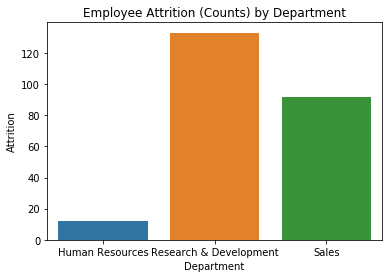

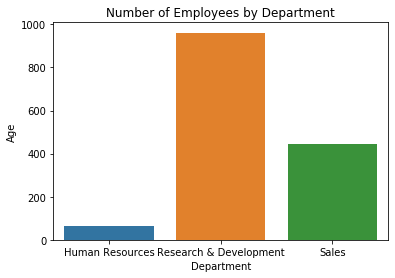

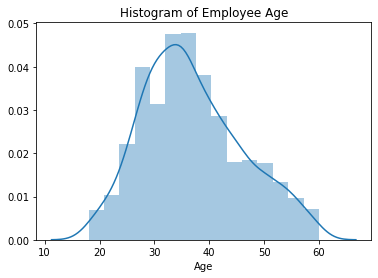

In [5]:
# Plot the attrition rates for each department
## Start by pulling out all of the Yes Attrition rows then group by department and plot
df_temp = df
templist = []
for i, val in enumerate (df_temp.Attrition):
    if val == 'No':
        templist.append(i)

df_temp = df_temp.drop(templist, axis = 0)
df_temp

# Plot
plot_data = df_temp.groupby(['Department'])['Attrition'].count().reset_index()

sns.barplot(x = 'Department', y = "Attrition", data = plot_data).set_title("Employee Attrition (Counts) by Department")
plt.show()

# Plot the total employees per department
sns.barplot(x = 'Department', y = "Age", data = df.groupby('Department').count().reset_index()).set_title("Number of Employees by Department")
plt.show()

# Plot the distribution of Employee Age
sns.distplot(a = df.Age, bins = 15).set_title("Histogram of Employee Age")
plt.show()

# Plot totals of Attrition
data = [go.Bar(
            x=df["Attrition"].value_counts().index.values,
            y= df["Attrition"].value_counts().values
    )]

py.iplot(data, filename='basic-bar')


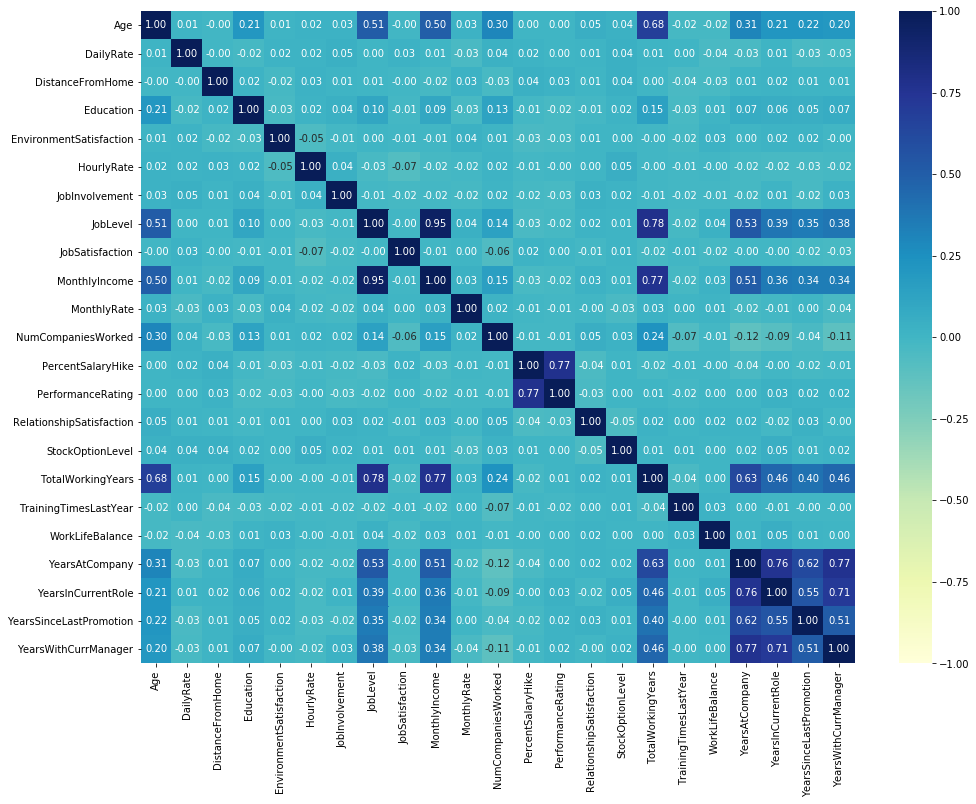

In [6]:
# Correlation Matrix testing for multicollinearity
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), cmap='YlGnBu', annot=True, fmt='.2f', vmin=-1);

There are several variables correlated with one another. Job level correlates to Monthly Income and Total working years. Years at Company, Yeast in Current Role, Years since last promotion, and years with current manager are all correlated with each other. We will need to figure out what to do with all of these to reduce the multicollinearity in the data. Performance rating and salary hike are correlated. We will drop performance rating under the assumption that a larger hike means a higher performance rating. 

Monthly Rate and Monthly Income are not correlated and neither is Hourly Rate. Are all of these referring to salary?

Note: The correlation matrix only works on numeric data so no categorical dtypes are represented. 

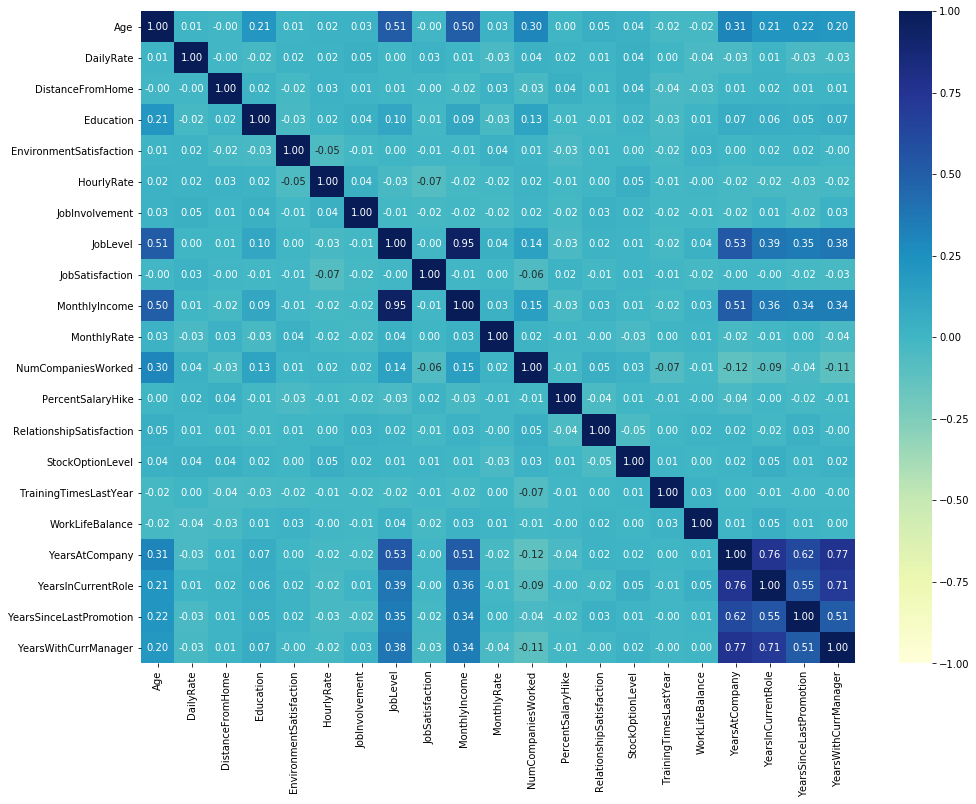

In [7]:
plt.figure(figsize=(16, 12))
sns.heatmap(df.drop(["TotalWorkingYears", "PerformanceRating"], axis = 1).corr(), cmap='YlGnBu', annot=True, fmt='.2f', vmin=-1);

# SMOTE - Synthetic Minority Oversampling Technique
Because we see such an imbalance between employees that have left the company and those who have stayed, we cannot take a random sample for the training and testing set for the predictive models. In order to prevent the models from using a majority rules prediction method, which would classify all test observations as employees who stay at the company, we will need to synthetically sample the data to account for the imbalance. 

Essentially what SMOTE does is take a random eample of the minority class and plots it. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space. The first observation is the starting point and the neighbors are selected as "end points". These end points are different from the original and a new observation is synthesized by finding the values between the original observation and its neighbor. 

Citation: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

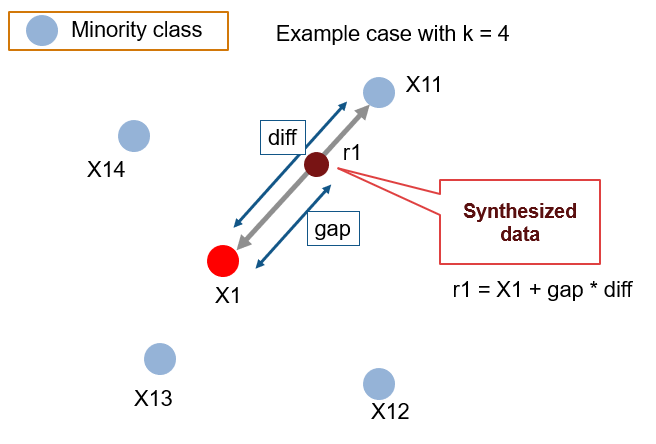


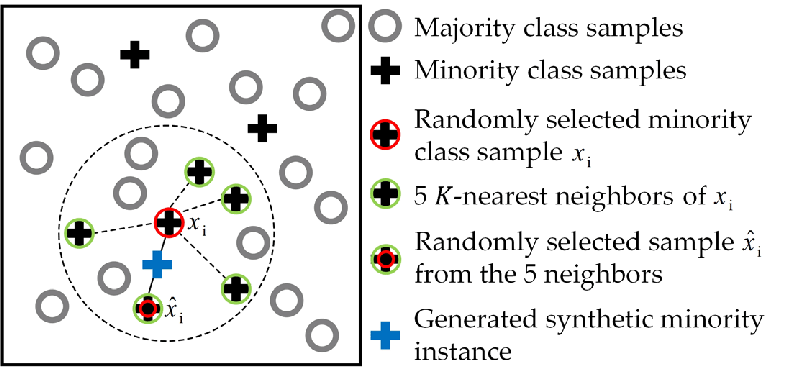

## Oversampling vs Undersampling:
In oversampling techniques, more observations are created for the minority class to bring the distribution to the desired level.

In undersampling techniques, the data is not sampled equally. The majority class is only sampled to the extent of the minority class to achieve the desired distribution. 

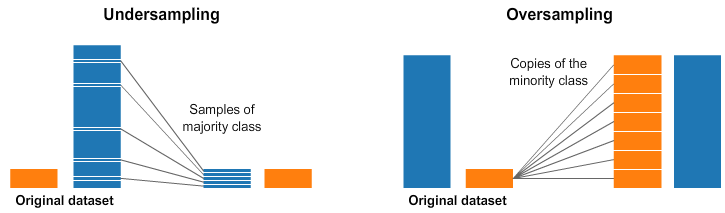


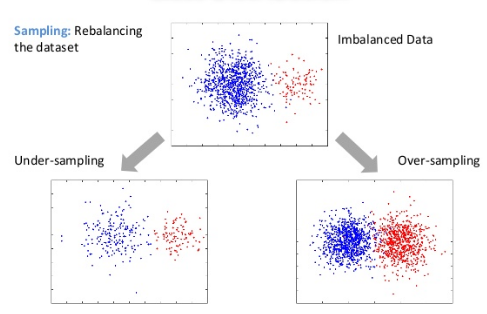

In [8]:
# Changing Attrition column into 1 (Yes) or 0 (No)
att = []
gen = []
for i in df.Attrition:
    if i == "Yes":
        att.append(1)
    else:
        att.append(0)
# Changing Gender column into 1 (Male) and 0 (Female)
for i in df.Gender:
    if i == "Male":
        gen.append(1)
    else:
        gen.append(0)
df.Attrition = att
df.Gender = gen

#### We will also need to dummy code the categorical variables: 

BusinessTravel              


Department                  

EducationField              

Gender                      

JobRole                     

MaritalStatus               

OverTime                    

In [9]:
# Store column names that need to be One Hot encoded in a list and use pandas get_dummies to encode categorical columns
cols = ["BusinessTravel", "Department", "EducationField", "JobRole", "MaritalStatus", "OverTime"]
df1 = pd.get_dummies(df, columns = cols)

In [10]:
# Separate out into labels and data to prep for SMOTE
y = df1.Attrition
X = df1.drop("Attrition", axis = 1)

In [11]:
# Initial distribution of labels
counter = Counter(y)
print(counter)

Counter({0: 1233, 1: 237})


In [12]:
# Using SMOTE to create synthetic observations for label = 1
oversample = imblearn.over_sampling.SMOTE(random_state = 420)
X1, y1 = oversample.fit_resample(X, y)
counter = Counter(y1)
print(counter)

Counter({1: 1233, 0: 1233})


In [13]:
# Split into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = .25, random_state = 420)

# Modeling
Random Forest

Naive Bayes

SVM -- NOPE

Gradient Boosted Classifier

0.9124797406807131
Random Forest Confusion Matrix
 [[290  21]
 [ 33 273]]
Random Forest Classification Report

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       311
           1       0.93      0.89      0.91       306

    accuracy                           0.91       617
   macro avg       0.91      0.91      0.91       617
weighted avg       0.91      0.91      0.91       617



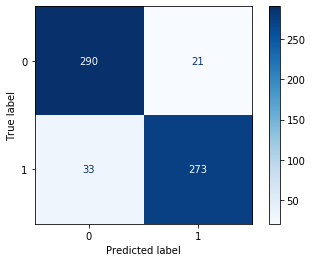

In [14]:
# Random Forest
randomf = RandomForestClassifier()

# Use the GridSearchCV funciton to explore the best parameters for RF
grid = {'n_estimators': [100,200,300,400,500], 'max_depth': [2,5,10]}
#{'max_depth': 10, 'n_estimators': 200}

rf_params = GridSearchCV(randomf, grid, cv=5)
RF_MODEL = rf_params.fit(X_train, y_train)

predicted_randomf = rf_params.predict(X_test)

accuracy_rf = accuracy_score(predicted_randomf, y_test)
print(accuracy_rf)

cnf_matrix = confusion_matrix(y_test, predicted_randomf)

print("Random Forest Confusion Matrix\n", cnf_matrix)

disp = plot_confusion_matrix(RF_MODEL, X_test, y_test, cmap = plt.cm.Blues)

print("Random Forest Classification Report\n")
print(classification_report(y_test, predicted_randomf))

Random Forest Most Informative Features



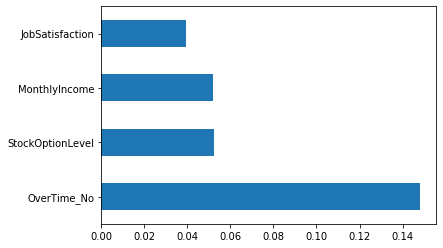

In [15]:
# List featrue importance for Random Forest model using 500 estimators
print("Random Forest Most Informative Features\n")
rf = RandomForestClassifier(n_estimators = 500, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(4).plot(kind='barh')

## Naive Bayes

In [16]:
# Most informative features function for Naive Bayes: 
def show_most_informative_features(df, clf, n=5):
    feature_names = df.columns.tolist()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

Multinomial Naive Bayes Confusion Matrix
 [[164 147]
 [126 180]]
Multinomial Naive Bayes Most Informative Features

	-15.6273	JobRole_Research Director		-0.3109	MonthlyRate    
	-15.1164	EducationField_Human Resources		-1.5088	MonthlyIncome  
	-15.1164	JobRole_Manager		-3.2838	DailyRate      
	-14.6464	JobRole_Healthcare Representative		-5.7050	HourlyRate     
	-14.5286	Department_Human Resources		-6.3987	Age            
Multinomial Naive Bayes Classification Report

              precision    recall  f1-score   support

           0       0.57      0.53      0.55       311
           1       0.55      0.59      0.57       306

    accuracy                           0.56       617
   macro avg       0.56      0.56      0.56       617
weighted avg       0.56      0.56      0.56       617



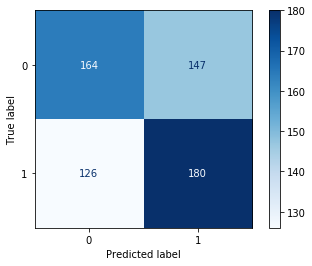

In [17]:
# Naive Bayes 
NB = MultinomialNB()
NB_MODEL = NB.fit(X_train, y_train)
# Predict the test set
NB_PREDICT = NB_MODEL.predict(X_test)
#Build confusion matrix
cnf_matrix = confusion_matrix(y_test, NB_PREDICT)

print("Multinomial Naive Bayes Confusion Matrix\n", cnf_matrix)
print("Multinomial Naive Bayes Most Informative Features\n")
show_most_informative_features(X_train, NB_MODEL)
disp = plot_confusion_matrix(NB_MODEL, X_test, y_test, cmap = plt.cm.Blues)
 
print("Multinomial Naive Bayes Classification Report\n")
print(classification_report(y_test, NB_PREDICT))

## SVMs are taking too long to train for this data set. Nixing this idea.
#### Going to take a subset of the training data to find optimal parameters. 
### It is taking way too long to run on the full training data 

#### Function for finding best params for SVM 
def svc_param_selection(X, y, nfolds, kernel, c_range, gamma_range):
    Cs = list(c_range)
    gammas = list(gamma_range)
    param_grid = {'C': Cs, 'gamma':gammas}
    grid_search = GridSearchCV(svm.SVC(kernel = kernel), param_grid, cv = nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_
    
    
param_df = X_train.copy(deep = True) 
param_df.insert(loc = 0, column = "Attrition", value = y_train)
param_test = param_df.sample(frac = .15, random_state = 420)
X_param = param_test.drop("Attrition", axis = 1)
y_param = param_test.Attrition
print(svc_param_selection(X_param, y_param, 2, 'linear', np.arange(0, 1, .5), np.arange(0, 1, .5))) 
#print(svc_param_selection(X_train, y_train, 2, 'linear', np.arange(.1, 1.1, .2), np.arange(.1, 1.1, .2))) 

## Gradient Boosted Classification
A gradient boosted classification system functions much like a random forest that ensembles several decision trees that are not accurate by themselves. A gradient boosted classification system takes a funciton that you want to minimize and a method by which to minimize it. 

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [21]:
# First set up the parameters for the GB 
gb_param = {
    'n_estimators': 1500,
    'max_features': 0.9,
    'max_depth': 4,
    'min_samples_leaf': 2,
    'subsample': 1,
    'max_features': 'sqrt',
    'random_state': 420,
    'verbose': 0
           }

Gradient Boosting Classifier Confusion Matrix
 [[296  15]
 [ 27 279]]
Gradient Boosting Classifier Classification Report

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       311
           1       0.95      0.91      0.93       306

    accuracy                           0.93       617
   macro avg       0.93      0.93      0.93       617
weighted avg       0.93      0.93      0.93       617



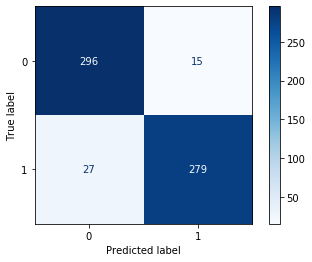

In [26]:
gb = GradientBoostingClassifier(**gb_param)
GB_MODEL = gb.fit(X_train, y_train)
GB_PREDICT = GB_MODEL.predict(X_test)

#Build confusion matrix
cnf_matrix = confusion_matrix(y_test, GB_PREDICT)

print("Gradient Boosting Classifier Confusion Matrix\n", cnf_matrix)

disp = plot_confusion_matrix(GB_MODEL, X_test, y_test, cmap = plt.cm.Blues)
 
print("Gradient Boosting Classifier Classification Report\n")
print(classification_report(y_test, GB_PREDICT))

Random Forest Most Informative Features



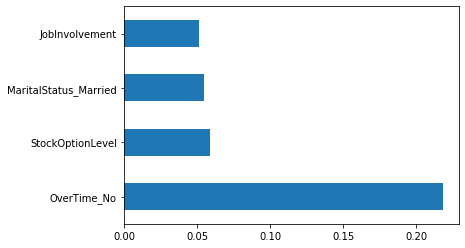

In [27]:
# Plot most important features for the GB model
print("Gradient Boosted Classifier Most Informative Features\n")
feat_importances = pd.Series(GB_MODEL.feature_importances_, index=X_train.columns)
feat_importances.nlargest(4).plot(kind='barh')

### Gradient Boosted Classifiers vs Random Forest
##### Bias vs Variance
A high bias would describe a model that is underfitted to the model and a model with a high variance would be overfitted to the data.
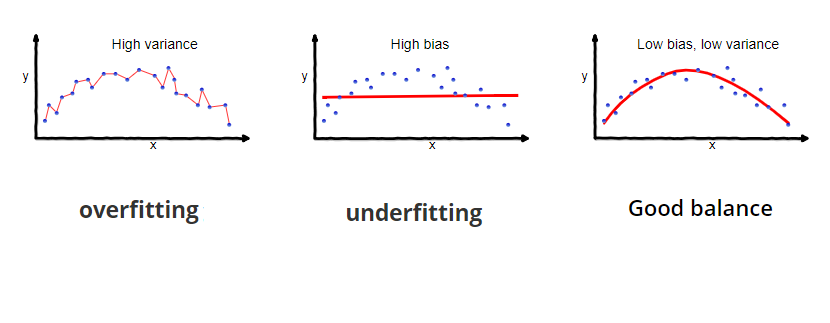

##### Random Forest
Both models use ensemble techniques to make decisions. The difference is that the random forest uses fully developed trees (low bias, high variance) to make many predictions using the overfitted trees. These predictions are then aggregated together to produce a single prediction. 
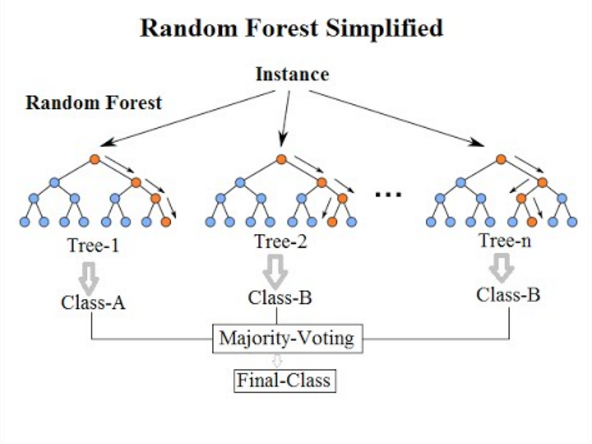

##### Gradient Boosted Classifiers
Gradient boosted classifiers work in similar ways but instead of using fully developed trees with a low bias/high variance, they use weak learner trees that have a high variance with a low bias. These are very generalized trees that are used to compute log(odds) of an instance. These computations are then used in the next tree which will give another value for the log(odds). This is repeated until the final tree has computed the final prediction. 
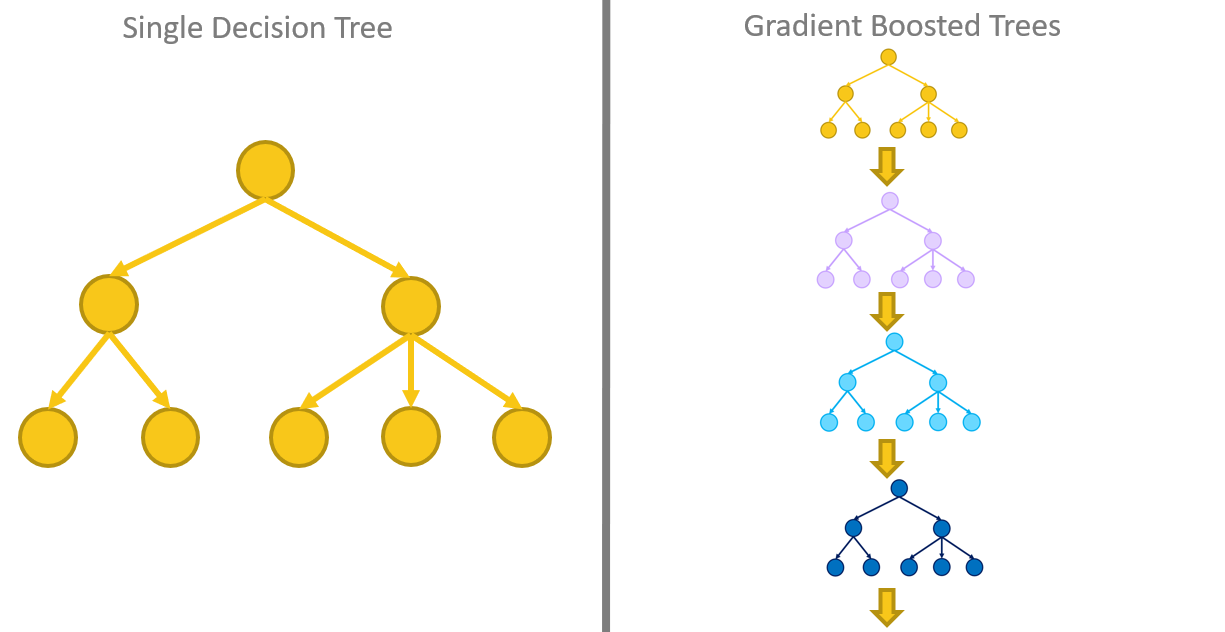

# Conclusions
The random forest and gradient boosted classifier models performed well on the SMOTE adjusted data. They achieved accuracies of 91% and 93%, respectively, when applied to the testing set. This might seem really good, but just taking a majority rules guess on the original data set would yield almost 84% accuracy. Since we are able to better this accuracy by 6% and 7%, we can say our models do perform better than a majority rules model; however, looking at the precision, recall, and F1 measures will probably be better metrics of evaluation. 

The naive bayes model did not perform well at all. It produced a testing accuracy of only 56% which is only slighly better than a random guess would theoretically produce. 

SVM was taking far too long to train on this data set. I might try in Spyder or in R to see if it can run it a bit faster, but I am not holding my breath for success on that. 

The SMOTE method for oversampling the minority class seemed to work well, although we did not train models on the original data before transformation. For comparison, however, it might be beneficial to train models on the pre-transformation data to see how well they are able to pick up on the minority class. This will be a good section to include in the presentation and the documentation to the web page used is listed above. 

### To Do:
- Figure out how to take care of the high correlations in the bottom right corner of the confusion matrix (Years at company, Years in current position, Years since last promotion, Years with current manager)
- Implement another model? (Logit/probit regression, kNN)
- If another model out performs the majority rules threshold, ensemble to see if accuracy can be increased
- Maybe run some CV on the naive bayes to see if we can boost accuracy a bit
- Run models on the pre-transformation data for comparison
- More Viz and EDA 